# SARIMAX

In [1]:
import sys
import os
sys.path.append('../')  # Go up to src/ directory

import numpy as np
from dataset import load_and_preprocess_arimax_data
from models import SARIMAX_model
import matplotlib.pyplot as plt
import json

from tune_hyperparameters import tune_hyperparameters

# Data Setup

In [2]:
df = load_and_preprocess_arimax_data('../../data/energy_data.csv')

target = 'spot'
exog_vars = ['wind_forecast_dah_mw', 'consumption_forecast_dah_mw', 
             'temp_forecast_dah_celcius', 'temp_norm_celcius',
             'heating_demand_interaction', 'temp_deviation', 'spot_lag1']

# Train/test split (80/20)
split_idx = int(len(df) * 0.8)
train_data = df.iloc[:split_idx].copy()
test_data = df.iloc[split_idx:].copy()

y_train = train_data[target].values
X_train = train_data[exog_vars].values

y_test = test_data[target].values
X_test = test_data[exog_vars].values

# ARIMAX Load or search

In [3]:
model = SARIMAX_model()
try:
    model.load("SARIMAX_model.pkl")
except Exception as e:
    model = SARIMAX_model().auto_train(y_train, X_train, max_p=5, max_q=5)
    model.save("SARIMAX_model.pkl")

# ARIMAX Predictions and plot

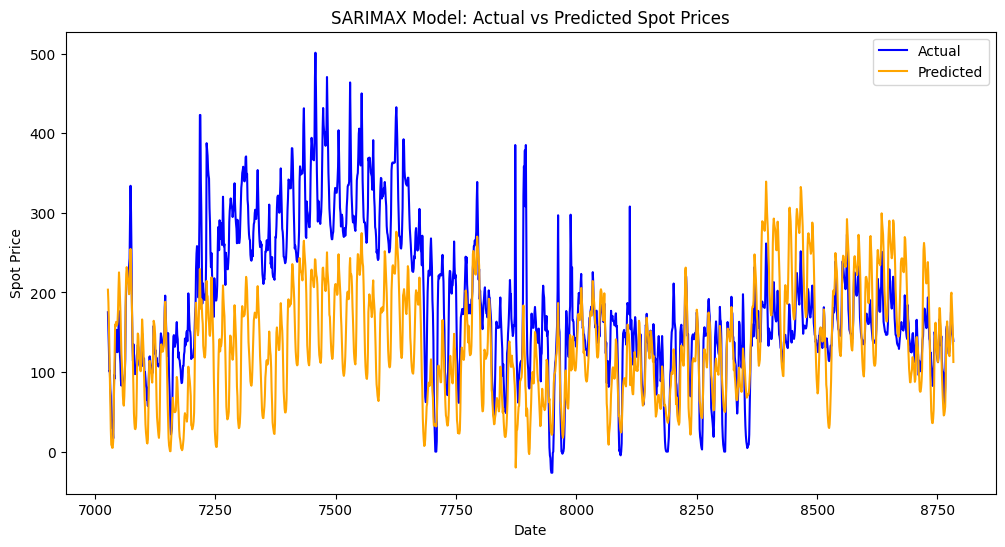

In [4]:
predictions = model.predict(y_train=y_train, X_train=X_train, X_test=X_test, steps=len(y_test))


plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual', color='blue')
plt.plot(test_data.index, predictions, label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Spot Price')
plt.title('SARIMAX Model: Actual vs Predicted Spot Prices')
plt.legend()
plt.show()

# Hyperparameter tuning

In [5]:
# Check if tuned parameters already exist

params_file = 'tuned_params_sarimax.json'

if os.path.exists(params_file):
    print(f"Loading existing parameters from {params_file}")
    with open(params_file, 'r') as f:
        tuned_params = json.load(f)
    best_params_basic = tuned_params['basic']
    best_params_cutoff = tuned_params['cutoff']
else:
    print("No existing parameters found. Running hyperparameter tuning...")
    best_params_basic,best_params_cutoff = tune_hyperparameters(predictions, y_test, n_trials=10000, save_path=params_file)

Loading existing parameters from tuned_params_sarimax.json


# ARIMAX ODG

In [6]:
from OGD import OGD_Predictor

actuals = y_test

ogd = OGD_Predictor(alpha=0.1, eta=best_params_basic['eta'], q_init=best_params_basic['q_init'])

for t in range(len(predictions)):
    y_pred = predictions[t]
    y_true = actuals[t]
    
    lower, upper = ogd.get_interval(y_pred)
    covered = ogd.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * ogd.q
        threshold = ogd.q
        
    if t % 100 == 0:
        lower, upper = ogd.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={ogd.q:.2f}")

print("\n ")
print(f"Coverage Rate: {ogd.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {ogd.q:.2f}")
print(f"Average Width: {np.mean(ogd.threshold_history)*2:.2f}")
print(f"Median Width: {np.median(np.array(ogd.threshold_history))*2:.2f}")

misses = sum(1 for c in ogd.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(ogd.coverage_history)}")

t=0: [167.15, 239.76], pred=203.46, true=175.11, covered=True, q=36.31
t=100: [48.61, 139.88], pred=94.24, true=110.15, covered=True, q=45.64
t=200: [-0.03, 240.52], pred=120.24, true=192.67, covered=True, q=120.28
t=300: [-119.85, 325.97], pred=103.06, true=253.22, covered=True, q=222.91
t=400: [61.92, 395.78], pred=228.85, true=354.17, covered=True, q=166.93
t=500: [15.25, 367.76], pred=191.51, true=334.96, covered=True, q=176.26
t=600: [103.97, 437.83], pred=270.90, true=415.45, covered=True, q=166.93
t=700: [-67.32, 210.55], pred=71.61, true=100.16, covered=True, q=138.94
t=800: [-55.44, 147.80], pred=46.18, true=52.50, covered=True, q=101.62
t=900: [-81.46, 177.76], pred=48.15, true=120.91, covered=True, q=129.61
t=1000: [60.75, 245.33], pred=153.04, true=167.83, covered=True, q=92.29
t=1100: [37.12, 165.71], pred=101.42, true=118.88, covered=True, q=64.30
t=1200: [176.22, 286.15], pred=231.18, true=219.97, covered=True, q=54.97
t=1300: [65.92, 138.53], pred=102.23, true=115.66, c

# ARIMAX ECI_basic

In [7]:
from OGD import ECI_Predictor

actuals = y_test

eci_basic = ECI_Predictor(alpha=0.1, eta=best_params_basic['eta'], q_init=best_params_basic['q_init'], version='basic', eq_function=best_params_basic['eq_function'])

for t in range(len(predictions)):
    y_pred = predictions[t]
    y_true = actuals[t]
    
    lower, upper = eci_basic.get_interval(y_pred)
    covered = eci_basic.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * eci_basic.q
        threshold = eci_basic.q
        
    if t % 100 == 0:
        lower, upper = eci_basic.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_basic.q:.2f}")

    if t % (len(predictions) -1) == 0:
        lower, upper = eci_basic.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_basic.q:.2f}")
print("\n ")
print(f"Coverage Rate: {eci_basic.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {eci_basic.q:.2f}")
print(f"Average Width: {np.mean(eci_basic.threshold_history)*2:.2f}")
print(f"Median Width: {np.median(np.array(eci_basic.threshold_history))*2:.2f}")

misses = sum(1 for c in eci_basic.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(eci_basic.coverage_history)}")

t=0: [167.15, 239.76], pred=203.46, true=175.11, covered=True, q=36.31
t=0: [167.15, 239.76], pred=203.46, true=175.11, covered=True, q=36.31
t=100: [46.84, 141.64], pred=94.24, true=110.15, covered=True, q=47.40
t=200: [4.22, 236.27], pred=120.24, true=192.67, covered=True, q=116.02
t=300: [-108.70, 314.82], pred=103.06, true=253.22, covered=True, q=211.76
t=400: [60.81, 396.89], pred=228.85, true=354.17, covered=True, q=168.04
t=500: [19.61, 363.40], pred=191.51, true=334.96, covered=True, q=171.90
t=600: [106.48, 435.32], pred=270.90, true=415.45, covered=True, q=164.42
t=700: [-67.15, 210.38], pred=71.61, true=100.16, covered=True, q=138.77
t=800: [-59.88, 152.24], pred=46.18, true=52.50, covered=True, q=106.06
t=900: [-82.52, 178.82], pred=48.15, true=120.91, covered=True, q=130.67
t=1000: [64.10, 241.98], pred=153.04, true=167.83, covered=True, q=88.94
t=1100: [40.55, 162.29], pred=101.42, true=118.88, covered=True, q=60.87
t=1200: [176.90, 285.47], pred=231.18, true=219.97, cove

# ARIMAX ECI_cutoff

In [8]:
from OGD import ECI_Predictor

actuals = y_test

eci_cutoff = ECI_Predictor(alpha=0.1, eta=best_params_cutoff['eta'], q_init=best_params_cutoff['q_init'], c=best_params_cutoff['c'], h=best_params_cutoff['h'], window_length=best_params_cutoff['window_length'], version='cutoff', eq_function=best_params_cutoff['eq_function'])

for t in range(len(predictions)):
    y_pred = predictions[t]
    y_true = actuals[t]
    
    lower, upper = eci_cutoff.get_interval(y_pred)
    covered = eci_cutoff.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * eci_cutoff.q
        threshold = eci_cutoff.q
        
    if t % 100 == 0:
        lower, upper = eci_cutoff.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_cutoff.q:.2f}")

    if t % (len(predictions) -1) == 0:
        lower, upper = eci_cutoff.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_cutoff.q:.2f}")
print("\n ")
print(f"Coverage Rate: {eci_cutoff.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {eci_cutoff.q:.2f}")
print(f"Average Width: {np.mean(eci_cutoff.threshold_history)*2:.2f}")
print(f"Median Width: {np.median(np.array(eci_cutoff.threshold_history))*2:.2f}")

misses = sum(1 for c in eci_cutoff.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(eci_cutoff.coverage_history)}")

t=0: [147.17, 259.74], pred=203.46, true=175.11, covered=True, q=56.28
t=0: [147.17, 259.74], pred=203.46, true=175.11, covered=True, q=56.28
t=100: [55.74, 132.75], pred=94.24, true=110.15, covered=True, q=38.51
t=200: [8.15, 232.34], pred=120.24, true=192.67, covered=True, q=112.10
t=300: [-119.24, 325.36], pred=103.06, true=253.22, covered=True, q=222.30
t=400: [66.56, 391.15], pred=228.85, true=354.17, covered=True, q=162.30
t=500: [21.95, 361.06], pred=191.51, true=334.96, covered=True, q=169.56
t=600: [107.31, 434.49], pred=270.90, true=415.45, covered=True, q=163.59
t=700: [-69.49, 212.71], pred=71.61, true=100.16, covered=True, q=141.10
t=800: [-57.14, 149.50], pred=46.18, true=52.50, covered=True, q=103.32
t=900: [-82.02, 178.32], pred=48.15, true=120.91, covered=True, q=130.17
t=1000: [63.93, 242.15], pred=153.04, true=167.83, covered=True, q=89.11
t=1100: [38.47, 164.36], pred=101.42, true=118.88, covered=True, q=62.95
t=1200: [188.76, 273.60], pred=231.18, true=219.97, cove

# ARIMAX ECI_integral

In [9]:
from OGD import ECI_Predictor

actuals = y_test

eci_integral = ECI_Predictor(alpha=0.1, eta=best_params_basic['eta'], q_init=best_params_basic['q_init'], version='integral', c=best_params_cutoff['c'], h=best_params_cutoff['h'], window_length=best_params_cutoff['window_length'], eq_function=best_params_basic['eq_function'])

for t in range(len(predictions)):
    y_pred = predictions[t]
    y_true = actuals[t]
    
    lower, upper = eci_integral.get_interval(y_pred)
    covered = eci_integral.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * eci_integral.q
        threshold = eci_integral.q
        
    if t % 100 == 0:
        lower, upper = eci_integral.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_integral.q:.2f}")
    if t % (len(predictions) -1) == 0:
        lower, upper = eci_integral.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci_integral.q:.2f}")
print("\n ")
print(f"Coverage Rate: {eci_integral.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {eci_integral.q:.2f}")
print(f"Average Width: {np.mean(eci_integral.threshold_history)*2:.2f}")
print(f"Median Width: {np.median(np.array(eci_integral.threshold_history))*2:.2f}")

misses = sum(1 for c in eci_integral.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(eci_integral.coverage_history)}")

t=0: [167.20, 239.71], pred=203.46, true=175.11, covered=True, q=36.25
t=0: [167.20, 239.71], pred=203.46, true=175.11, covered=True, q=36.25
t=100: [37.64, 150.85], pred=94.24, true=110.15, covered=True, q=56.61
t=200: [20.92, 219.57], pred=120.24, true=192.67, covered=True, q=99.33
t=300: [-140.74, 346.87], pred=103.06, true=253.22, covered=True, q=243.80
t=400: [62.81, 394.90], pred=228.85, true=354.17, covered=True, q=166.05
t=500: [3.70, 379.32], pred=191.51, true=334.96, covered=True, q=187.81
t=600: [103.77, 438.03], pred=270.90, true=415.45, covered=True, q=167.13
t=700: [-53.08, 196.31], pred=71.61, true=100.16, covered=True, q=124.70
t=800: [-54.54, 146.90], pred=46.18, true=52.50, covered=True, q=100.72
t=900: [-92.18, 188.48], pred=48.15, true=120.91, covered=True, q=140.33
t=1000: [60.14, 245.93], pred=153.04, true=167.83, covered=True, q=92.89
t=1100: [22.88, 179.95], pred=101.42, true=118.88, covered=True, q=78.54
t=1200: [173.00, 289.37], pred=231.18, true=219.97, cover

# Conformal Inference plotting

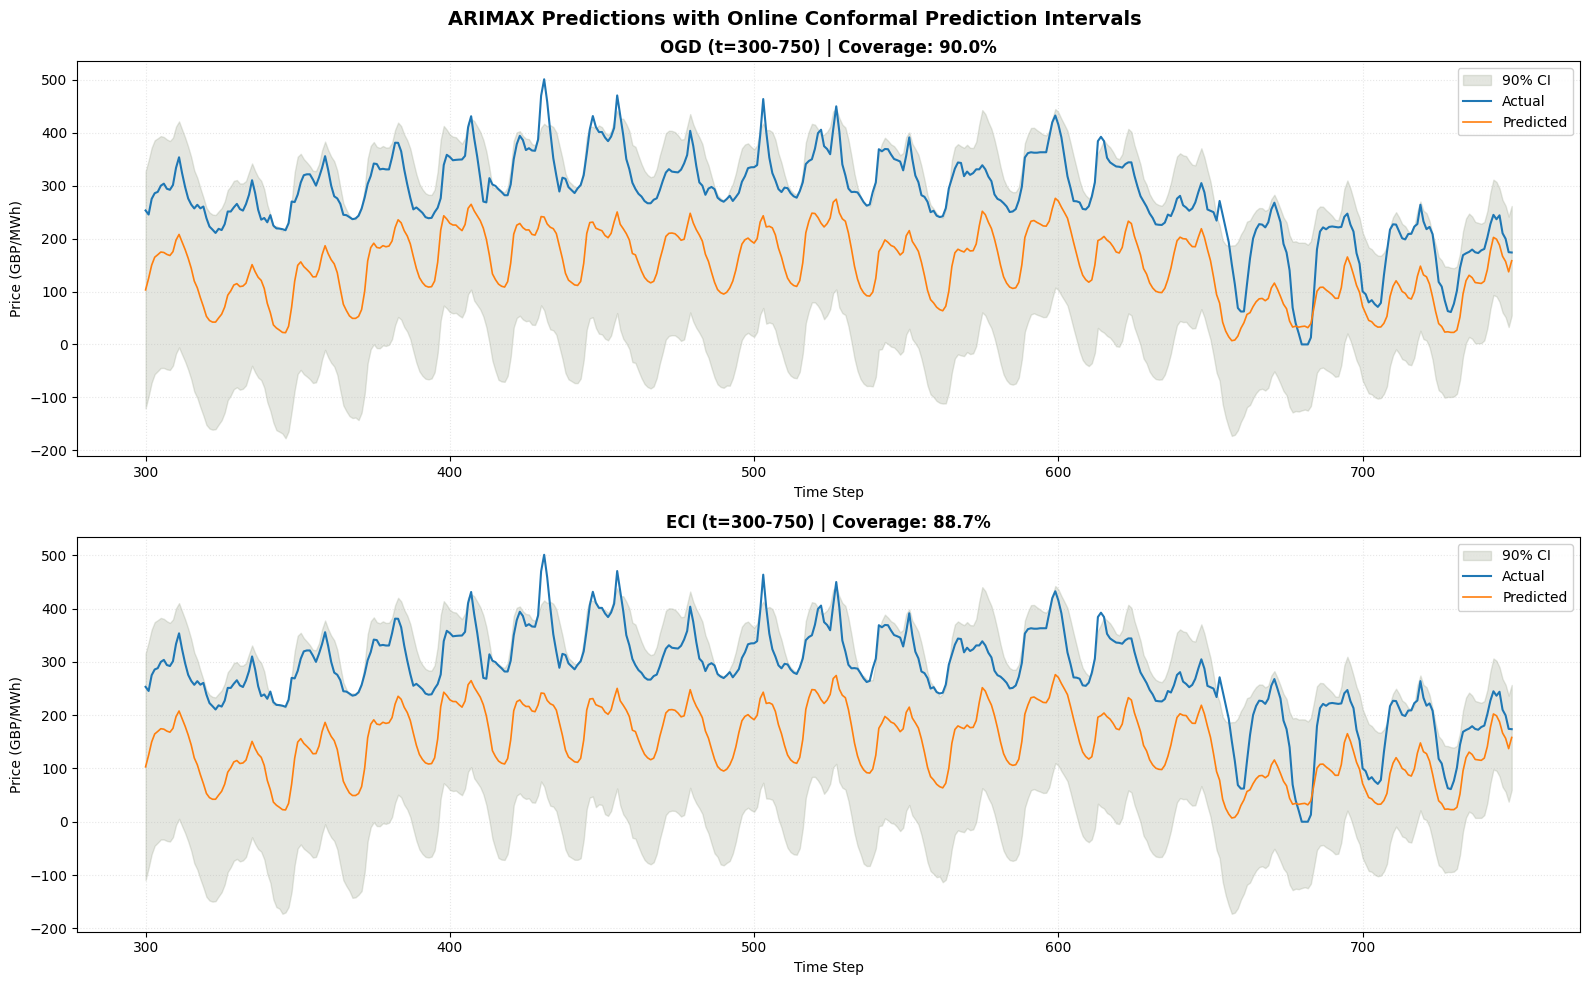

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def get_intervals_from_history(predictions, threshold_history, q_init):
    """Reconstruct intervals from threshold history.
    
    threshold_history[t] contains q AFTER the update at time t.
    The interval at time t uses the q value BEFORE the update (i.e., from t-1).
    """
    # At t=0, we use q_init; at t>0, we use q from previous step
    q_values = [q_init] + list(threshold_history[:-1])
    q_values = np.array(q_values)
    lowers = predictions - q_values
    uppers = predictions + q_values
    return lowers, uppers

# Get intervals for both methods
ogd_lower, ogd_upper = get_intervals_from_history(predictions, ogd.threshold_history, q_init=50)
eci_lower, eci_upper = get_intervals_from_history(predictions, eci_basic.threshold_history, q_init=10)

# Define zoom window
zoom_start, zoom_end = 300, 750
time_steps = np.arange(len(predictions))

# Create 2x1 subplot
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

def plot_ci(ax, time_range, lower, upper, preds, actuals, title, ci_color, pred_color):
    """Plot confidence interval on a given axis."""
    t = time_range
    ax.fill_between(t, lower[t], upper[t], alpha=0.25, color=ci_color, label='90% CI')
    ax.plot(t, actuals[t], linewidth=1.5, label='Actual', alpha=1.0)
    ax.plot(t, preds[t], linewidth=1.2, label='Predicted', alpha=1.0)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Step', fontsize=10)
    ax.set_ylabel('Price (GBP/MWh)', fontsize=10)
    ax.legend(loc='upper right', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle=':')

# OGD plot (zoomed)
ogd_coverage = ogd.get_coverage_rate()
plot_ci(axes[0], range(zoom_start, zoom_end), ogd_lower, ogd_upper,
        predictions, actuals,
        f'OGD (t={zoom_start}-{zoom_end}) | Coverage: {ogd_coverage:.1%}', 
        ci_color="#949D84FF", pred_color="#A50000")

# ECI plot (zoomed)
eci_coverage = eci_basic.get_coverage_rate()
plot_ci(axes[1], range(zoom_start, zoom_end), eci_lower, eci_upper,
        predictions, actuals,
        f'ECI (t={zoom_start}-{zoom_end}) | Coverage: {eci_coverage:.1%}', 
        ci_color="#949D84FF", pred_color='#BC4749')

plt.suptitle('ARIMAX Predictions with Online Conformal Prediction Intervals', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('arimax_conformal_intervals.png', dpi=300)
plt.show()